# Using Machine Learning to Predict Sleep Quality using FITBIT smartwatch data

In this project, We applied various Machine Learning models to predict Fitbit Sleep Scores based on a sample of almost one year from nearly 16 people's sleep score data. We compare the accuracies of  different models and look into the feature importances in each of the models.Using sleep scores we can find the sleep quality of a person.

## Import the relevant libraries and data

In [56]:
# Import all relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
print("All Libraries imported sudcessfuly")

All Libraries imported sudcessfuly


In [57]:
# Import the app data
sleep_stats_data = pd.read_csv('sleep_stats.csv')

# Import the score data
sleep_score_data = pd.read_csv('sleep_score.csv').iloc[:,:2]

In [58]:
# Inspect the first rows of the sleep stats DataFrame
sleep_stats_data.head()

,Sleep,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep
1,2020-07-01 10:05PM,2020-07-02 6:23AM,456,42,37,498,94,271,91
2,2020-06-30 9:43PM,2020-07-01 6:03AM,412,88,32,500,79,208,125
3,2020-06-29 10:03PM,2020-06-30 5:57AM,412,61,26,473,91,242,79
4,2020-06-28 11:24PM,2020-06-29 6:05AM,342,59,26,401,71,196,75


In [59]:
print("Hello")
# Make the first row the column headers

sleep_stats_data.columns = sleep_stats_data.iloc[0]
# Drop the first row from the DataFrame
sleep_stats_data.drop(sleep_stats_data.index[0], inplace=True)
sleep_stats_data


Hello


,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep
1,2020-07-01 10:05PM,2020-07-02 6:23AM,456,42,37,498,94,271,91
2,2020-06-30 9:43PM,2020-07-01 6:03AM,412,88,32,500,79,208,125
3,2020-06-29 10:03PM,2020-06-30 5:57AM,412,61,26,473,91,242,79
4,2020-06-28 11:24PM,2020-06-29 6:05AM,342,59,26,401,71,196,75
5,2020-06-27 10:42PM,2020-06-28 9:20AM,530,108,39,638,98,305,127
...,...,...,...,...,...,...,...,...,...
318,2019-07-12 11:11PM,2019-07-13 7:05AM,423,51,28,474,89,263,71
319,2019-07-11 9:58PM,2019-07-12 8:23AM,540,85,30,625,114,324,102
320,2019-07-10 9:43PM,2019-07-11 7:32AM,525,64,31,589,93,322,110
321,2019-07-09 9:12PM,2019-07-10 7:31AM,536,83,38,619,124,336,76


In [60]:
# Obtain some information about the DataFrame
sleep_stats_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 1 to 322
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Start Time            322 non-null    object
 1   End Time              322 non-null    object
 2   Minutes Asleep        322 non-null    object
 3   Minutes Awake         322 non-null    object
 4   Number of Awakenings  322 non-null    object
 5   Time in Bed           322 non-null    object
 6   Minutes REM Sleep     287 non-null    object
 7   Minutes Light Sleep   287 non-null    object
 8   Minutes Deep Sleep    287 non-null    object
dtypes: object(9)
memory usage: 25.2+ KB


In [6]:
# Inspect the first five rows with missing values
sleep_stats_data[sleep_stats_data['Minutes REM Sleep'].isna()].head()

,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep
77,2020-04-16 2:09PM,2020-04-16 3:27PM,76,2,0,78,NaN,NaN,NaN
103,2020-03-22 1:47PM,2020-03-22 3:21PM,83,1,1,93,NaN,NaN,NaN
115,2020-03-11 4:19PM,2020-03-11 5:24PM,55,6,1,65,NaN,NaN,NaN
121,2020-03-06 3:40PM,2020-03-06 4:40PM,53,7,0,60,NaN,NaN,NaN
134,2020-02-23 2:28PM,2020-02-23 3:42PM,68,5,0,74,NaN,NaN,NaN


Start and finishing times for the sleep stats with NaNs for REM, Light and Deep sleep refer to afternoon naps. These should be excluded from our data set as they do not have a sleep score or the necessary sleep stats attached to them.

In [7]:
# Drop rows with NaNs
sleep_stats_data.dropna(axis=0, inplace=True)

In [8]:
# Convert columns 2-8 to data type float
cols_to_convert = sleep_stats_data.columns[2:]
sleep_stats_data[cols_to_convert] = sleep_stats_data[cols_to_convert].astype(float)

In [9]:
sleep_stats_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 1 to 322
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Start Time            287 non-null    object 
 1   End Time              287 non-null    object 
 2   Minutes Asleep        287 non-null    float64
 3   Minutes Awake         287 non-null    float64
 4   Number of Awakenings  287 non-null    float64
 5   Time in Bed           287 non-null    float64
 6   Minutes REM Sleep     287 non-null    float64
 7   Minutes Light Sleep   287 non-null    float64
 8   Minutes Deep Sleep    287 non-null    float64
dtypes: float64(7), object(2)
memory usage: 22.4+ KB


In [10]:
# Inspect the first rows of the sleep score DataFrame
sleep_score_data.head()

,timestamp,overall_score
0,2020-07-02T06:23:30Z,86
1,2020-07-01T06:03:30Z,77
2,2020-06-30T05:57:00Z,78
3,2020-06-29T06:05:00Z,76
4,2020-06-28T09:20:30Z,82


In [11]:
# Inspect the summary for the sleep score df
sleep_score_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   timestamp      286 non-null    object
 1   overall_score  286 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ KB


I want to be able to merge the two DataFrames on the date. As of now there are slight differences in how the times are displayed. The sleep_stat DataFrame has both starting and ending dates but what we care about are ending dates (those are always the dates on which the sleep score is provided). I will drop the beginning date column, transform the dates so that they are in the same format across the two DataFrames and then merge the DataFrames on the date.

In [12]:
# Drop start time column from sleep_stat
sleep_stats_data.drop(columns='Start Time', inplace=True)

In [13]:
# Separate date into new column
sleep_stats_data['Date'] = sleep_stats_data['End Time'].apply(lambda x: x[:10])
sleep_score_data['Date'] = sleep_score_data.timestamp.apply(lambda x: x[:10])

In [14]:
# Merge the two DataFrames
joined_data = sleep_stats_data.merge(sleep_score_data, on='Date', how='left')
joined_data.head()

,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,Date,timestamp,overall_score
0,2020-07-02 6:23AM,456.0,42.0,37.0,498.0,94.0,271.0,91.0,2020-07-02,2020-07-02T06:23:30Z,86.0
1,2020-07-01 6:03AM,412.0,88.0,32.0,500.0,79.0,208.0,125.0,2020-07-01,2020-07-01T06:03:30Z,77.0
2,2020-06-30 5:57AM,412.0,61.0,26.0,473.0,91.0,242.0,79.0,2020-06-30,2020-06-30T05:57:00Z,78.0
3,2020-06-29 6:05AM,342.0,59.0,26.0,401.0,71.0,196.0,75.0,2020-06-29,2020-06-29T06:05:00Z,76.0
4,2020-06-28 9:20AM,530.0,108.0,39.0,638.0,98.0,305.0,127.0,2020-06-28,2020-06-28T09:20:30Z,82.0


In [15]:
# Drop redundant columns
sleep_data = joined_data.drop(columns=['End Time', 'timestamp', 'Date', 'Number of Awakenings'])

In [16]:
# Drop last nan
sleep_data.dropna(axis=0,inplace=True)

In [17]:
# Look at first five rows
sleep_data.head()

,Minutes Asleep,Minutes Awake,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score
0,456.0,42.0,498.0,94.0,271.0,91.0,86.0
1,412.0,88.0,500.0,79.0,208.0,125.0,77.0
2,412.0,61.0,473.0,91.0,242.0,79.0,78.0
3,342.0,59.0,401.0,71.0,196.0,75.0,76.0
4,530.0,108.0,638.0,98.0,305.0,127.0,82.0


572


## Visualise the relationships between features and sleep score

Finding relationship of each individual feature with overall sleep score.

In [19]:
# Define a function to plot the scatterplots of the relationships between all independent variables and the dependent
# variable
def plot_relationships(df, num_cols):
    variables = df.columns
    # This function assumes that the dependent variable is in the last column
    dep_var = variables[-1]
    ind_var = variables[:-1]
    figs = len(dep_var)
    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    fig = 1
    plt.figure(figsize=(20,30))
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

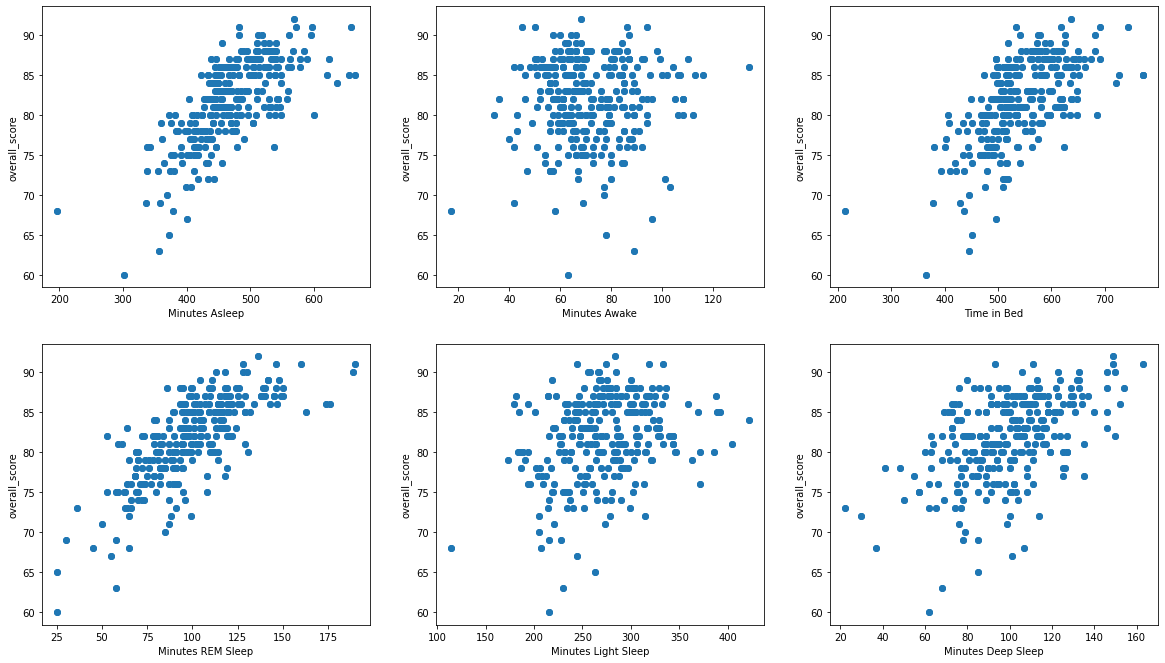

In [20]:
# Call the function with the reduced app data DataFrame and subplots in a grid of two columns
plot_relationships(sleep_data, 3)

Minutes Asleep and Minutes REM Sleep  have the strongest positive relationships with the overall sleep score. Generally speaking this makes sense because more time in bed should lead to more sleep, and therefore more quality sleep, and REM sleep has been found to be extremely important for many restorative functions and memory formation. 

<AxesSubplot:>

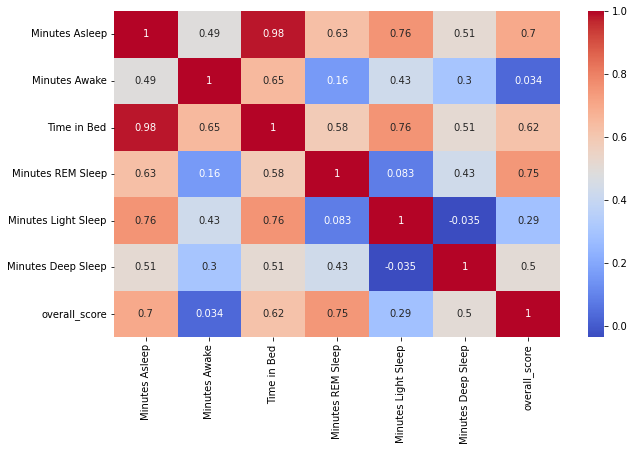

In [21]:
# Inspect the correlations
plt.figure(figsize=(10, 6))
sns.heatmap(sleep_data.corr(), annot=True, cmap='coolwarm', fmt='.2g')

## Inspect sleep score distribution

In [22]:
# Find spread of sleep score values
spread = int(max(sleep_data.overall_score) - min(sleep_data.overall_score))
spread

32

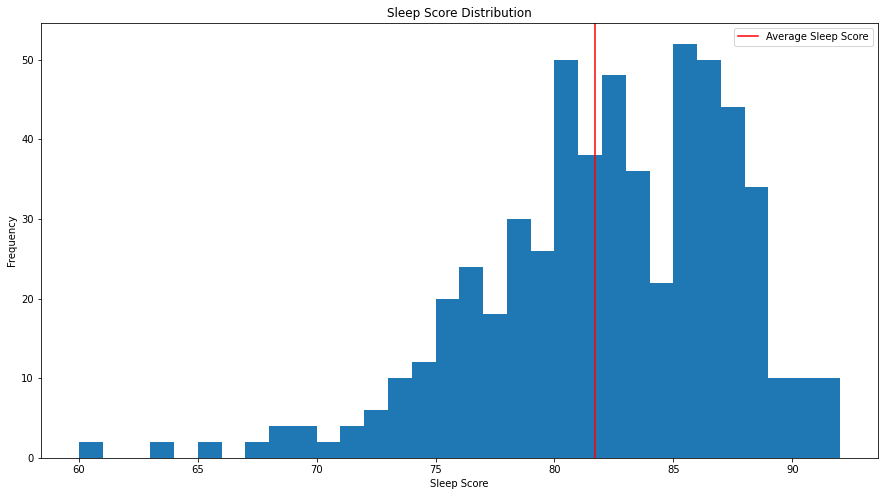

In [23]:
# Plot sleep score histogram and its mean
plt.figure(figsize=(15,8))
plt.hist(sleep_data.overall_score, bins=spread)
plt.axvline(sleep_data.overall_score.mean(), color='r', label='Average Sleep Score')
plt.xlabel('Sleep Score')
plt.ylabel('Frequency')
plt.title('Sleep Score Distribution')
plt.legend()

The distribution of sleep scores is skewed to the left. This makes sense because bad night sleeps are more likely to occur than exceptionally good ones due to multiple reasons such as staying out late, having to gte up extremely early, etc. Given that the average sleep score in the data set is already relatively high at 82 and the upper limit being 100, it is by definition difficult to have many outliers that lie above the average.

## Split the data into training, validation and test set

In [24]:
# Perform first split
X_train_temp, X_test, y_train_temp, y_test = train_test_split(sleep_data.iloc[:,:-1], 
                                                              sleep_data['overall_score'], test_size=0.2, 
                                                              random_state=42)

In [25]:
# Perform the second split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

In [26]:
# Check the lengths of the different subsets
len(X_train), len(X_valid), len(X_test)

(342, 115, 115)

In [27]:
len(X_valid.columns)

6

<AxesSubplot:>

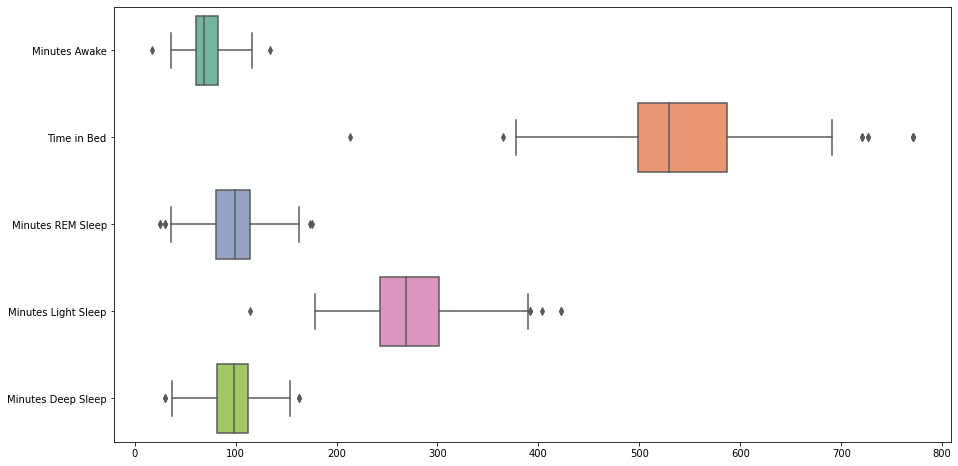

In [28]:
plt.figure(figsize=(15,8))
sns.boxplot(data=X_train.iloc[:,1:], orient='h', palette='Set2')

## Scaling the Features

Scaling the features

In [29]:
# Create the scaler with object range of 0-1
scaler = MinMaxScaler()

# Fit and transform using the training data
scaler.fit_transform(X_train)

# Transform the validation and test features
scaler.transform(X_valid)
scaler.transform(X_test)

array([[ 0.62473348,  0.47008547,  0.62365591,  0.46357616,  0.53896104,
         0.63157895],
       [ 0.68017058,  0.5982906 ,  0.69713262,  0.66225166,  0.52597403,
         0.63157895],
       [ 0.41791045,  0.36752137,  0.42831541,  0.58940397,  0.25      ,
         0.42857143],
       [ 0.5565032 ,  0.5042735 ,  0.5734767 ,  0.47019868,  0.4512987 ,
         0.58646617],
       [ 0.73134328,  0.72649573,  0.76702509,  0.47682119,  0.61038961,
         0.82706767],
       [ 0.51385928,  0.4957265 ,  0.53584229,  0.39735099,  0.46428571,
         0.4887218 ],
       [ 0.7782516 ,  0.4017094 ,  0.73835125,  0.69536424,  0.55519481,
         0.87218045],
       [ 0.4434968 ,  0.24786325,  0.42473118,  0.46357616,  0.37337662,
         0.37593985],
       [ 0.65671642,  0.57264957,  0.67204301,  0.46357616,  0.63636364,
         0.51879699],
       [ 0.57782516,  0.29059829,  0.54659498,  0.7615894 ,  0.32467532,
         0.62406015],
       [ 0.53944563,  0.44444444,  0.54659498,  0.

## Feature Selection using Lasso Regression

Fitting a linear regression minimises a loss function by choosing coefficients for each feature variable. One problem with that is that large coefficients can lead to overfitting, meaning that the model will perform well on the training data but poorly on data it has never seen before. This is where regularisation comes in. Essentially, you just alter the loss function to penalise large coefficients. Lasso Regression, unlike the closely related Ridge Regression, can be used to select important features of a dataset. This is because it tends tos hrink the coefficients of less important features to close to zero.

In [30]:
# Create the model
lasso = Lasso(alpha=0.1)

# Fit the model to the training data
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

Text(0.5, 1.0, 'Lasso coefficients for sleep data features')

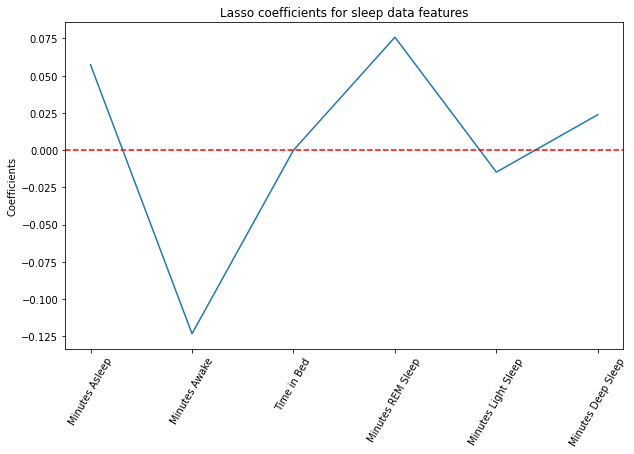

In [31]:
# Extract the coefficients
lasso_coef = lasso.coef_

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.plot(range(len(X_train.columns)), lasso_coef)
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=60)
plt.axhline(0.0, linestyle='--', color='r')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients for sleep data features')

The Lasso Regression algorithm has reduced the coefficients of Time in Bed and Minutes Light Sleep to close to zero, deeming them less important than the other four features. This comes in handy as we would face major multicollinearity issues if we included all of the features in our models. Multicollinearity itself is not an issue when you only care about predictive power of the model but it makes interpreting the model reliably almost impossible. I would like to buidl Machine Learning models that perform well but are also somewhat interpretable, which is why a reduction in multicollinearity is needed.

For further analysis I will only include Minutes Asleep, Minutes Awake, Minutes REM Sleep and Minutes Deep Sleep as features in the models.

In [32]:
# Create a list of the columns to drop
cols_to_drop = ['Time in Bed', 'Minutes Light Sleep']

# Drop these columns from training, validation and test data
X_train_temp.drop(columns=cols_to_drop, inplace=True)
X_train.drop(columns=cols_to_drop, inplace=True)
X_valid.drop(columns=cols_to_drop, inplace=True)
X_test.drop(columns=cols_to_drop, inplace=True)



## Defining performance measures

The performance measures I want to use to compare the different ML models are Accuracy and Score. Average Error is added to the list as an extra.

In [33]:
def scoring(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}.'.format(mae))
    print('Mean Squared Error: {:0.4f}.'.format(mse))
    print('R^2 Score = {:0.4f}.'.format(r2))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

Accuracy is typically used as a performance measure in classification problems and not regression problems because it refers to the proportion of correct predictions that the model makes. The ways I use accuracy for the regression models in this analysis is different. Accuracy for the regression models is a measure of how far off (in percentage terms) the prediction in sleep score will be from the actual sleep score, on average. For example, if the actual sleep score is 80 and the model has an accuracy of 96%, meaning that on average it is 4% off, the model is expected to make a prediction for the sleep score in the range of 76.8 (80 - (80 x 0.04)) to 83.2 (80 + (80 x 0.04)). 

## Establish a Baseline

The baseline that I will compare the performance of the Machine Learning models against will be simply predicting the average Sleep Score every night. A good model should be substantially better than just predicting the average every night.

In [34]:
# Create list of median predictions that has the same length as y_valid
baseline_y = [y_train.median()] * len(y_valid)

# Compute the relevant scores
base_predictions = baseline_y
base_mae = mean_absolute_error(y_valid, base_predictions)
base_mse = mean_squared_error(y_valid, base_predictions)
base_r2 = r2_score(y_valid, base_predictions)
base_errors = abs(base_predictions - y_valid)
base_mape = 100 * np.mean(base_errors / y_valid)
base_accuracy = 100 - base_mape
print('Model Performance')
print('Mean Absolute Error: {:0.4f}.'.format(base_mae))
print('Mean Squared Error: {:0.4f}.'.format(base_mse))
print('R^2 Score = {:0.4f}.'.format(base_r2))
print('Accuracy = {:0.2f}%.'.format(base_accuracy))

Model Performance
Mean Absolute Error: 3.7826.
Mean Squared Error: 22.0783.
R^2 Score = -0.0018.
Accuracy = 95.32%.


## Multiple Linear Regression

The first model I would like to use is MLR. I used MLR in another project to understand the relationship between the independent variables and the sleep score. This time, I will use it to make predictions about sleep scores and test the accuracy of this linear model.

In [35]:
# Create regressor
regressor = LinearRegression()

# Fit MLR model to training data
mlr = regressor.fit(X_train, y_train)

In [36]:
# Evaluate the performance
scoring(mlr, X_valid, y_valid)

Model Performance
Mean Absolute Error: 2.2955.
Mean Squared Error: 7.9884.
R^2 Score = 0.6375.
Accuracy = 97.20%.


In [37]:
# Inspect the statsmodel results
X_mlr = sm.add_constant(X_train)
est = sm.OLS(y_train, X_mlr)
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          overall_score   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     277.8
Date:                Mon, 06 Jun 2022   Prob (F-statistic):          2.69e-105
Time:                        07:28:22   Log-Likelihood:                -811.83
No. Observations:                 342   AIC:                             1634.
Df Residuals:                     337   BIC:                             1653.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 57.6855      1.060     54.423      0.000      55.601      59.770
Minutes Asleep         0.0426      0.003     12.220      0.000       0.036       0.049
Minutes Awake         -0.1238      0.010    -11.999      0.000      -0.144      -0.103
Minutes REM Sleep      0.0907      0.008     11.707      0.000       0.075       0.106
Minutes Deep Sleep     0.0388      0.008      5.088      0.000       0.024       0.054
==============================================================================
Omnibus:                        2.470   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                2.541
Skew:                          -0.200   Prob(JB):                        0.281
Kurtosis:                       2.863   Cond. No.                     3.74e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The coefficients in our model are close to those of the MLR using the entire dataset. Looking at the feature importances in combination with the sign of the coefficients provides an important insight (ignoring multicollinearity!). Minutes Awake seem to have the biggest impact on sleep score and because that variable has a negative coefficient, it's impact is a sleep score reducing one. Disregarding multicollinearity, these feature importances indicate that it takes more than two minutes of REM sleep to make up for one minute of being awake. Furthermore, REM sleep appears to be almost twice as important as deep sleep when it comes to their impact on sleep score.

## Random Forest

In [38]:
# Create regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Fit RF model to training data
rf = rf_regressor.fit(X_train, y_train)

In [39]:
# Evaluate the performance
scoring(rf, X_valid, y_valid)

Model Performance
Mean Absolute Error: 1.3712.
Mean Squared Error: 3.4979.
R^2 Score = 0.8413.
Accuracy = 98.32%.


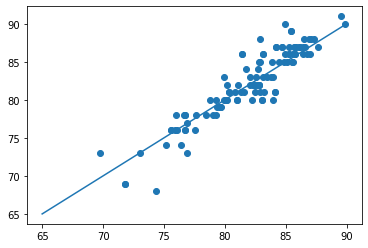

In [40]:
# Make predictions
y_pred = rf.predict(X_valid)

x = np.linspace(65, 90, 25)
y = x

plt.scatter(y_pred, y_valid)
plt.plot(x, y)

In [41]:
# Create a DataFrame of the feature importances 
rf_feats = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['Feature Importance'])
rf_feats

,Feature Importance
Minutes Asleep,0.486584
Minutes Awake,0.084792
Minutes REM Sleep,0.366589
Minutes Deep Sleep,0.062035


## Extreme Gradient Boosting 

In [42]:
# Create regressor
xgb_regressor = XGBRegressor(random_state=42)

# Fit model to training data
xgb = xgb_regressor.fit(X_train, y_train)

In [43]:
# Evaluate the performance
scoring(xgb, X_valid, y_valid)

Model Performance
Mean Absolute Error: 0.8483.
Mean Squared Error: 2.3663.
R^2 Score = 0.8926.
Accuracy = 98.97%.


In [44]:
# Create a DataFrame to inspect the feature importances again
xgb_feats = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['Feature Importance'])
xgb_feats

,Feature Importance
Minutes Asleep,0.277031
Minutes Awake,0.107531
Minutes REM Sleep,0.522831
Minutes Deep Sleep,0.092607


Interestingly, Minutes REM Sleep is by far the most important feature again and, similar to the Random Forest, Time in Bed is the second most important.

## Introducing Cross-Validation

Cross Validation is similar to that of splitting the data into training and testing data and can be thought of as a repeated train test split with subsequent testing of the model accuracy. In a train test split you train the model on one subset of the data and test it on the remaining data but you do that only once. In Cross Validation you perform multiple train test splits and for each split the test and training data are different. Basically, you split the data into a number of subsets, called folds, hold out one set at a time, train the model on the remaining data and test it on the hold out set. You repeat these steps until you have used every subset as the test set, i.e. by definition the number of times you perform these steps is equal to the number of folds you split the dataset into.

In [45]:
# Create the models to be tested
mlr_reg = LinearRegression()
rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = xgb_regressor = XGBRegressor(random_state=42)

In [46]:
# Put the models in a list to be used for cross validation
models = [mlr_reg, rf_reg, xgb_reg]

In [47]:
# Define a function that compares the CV perfromance of a set of predetrmined models 
def cv_comparison(models, X, y, cv):
    # Initiate a DataFrame for the averages and a list for all measures
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of all CVs to the list
    for model in models:
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4)
        maes.append(mae)
        mae_avg = round(mae.mean(), 4)
        mse = -np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4)
        mses.append(mse)
        mse_avg = round(mse.mean(), 4)
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        acc = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
        accs.append(acc)
        acc_avg = round(acc.mean(), 4)
        cv_accuracies[str(model)] = [mae_avg, mse_avg, r2_avg, acc_avg]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return cv_accuracies, maes, mses, r2s, accs

In [48]:
# Run the Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_train_temp, y_train_temp, 4)

In [49]:
# Change the columns of the compariosn table and return it
comp.columns = ['Multiple Linear Regression', 'Random Forest', 'Extreme Gradient Boosting']
comp

,Multiple Linear Regression,Random Forest,Extreme Gradient Boosting
Mean Absolute Error,2.1552,1.3412,0.9555
Mean Squared Error,7.3317,3.7917,3.7025
R^2,0.7279,0.8607,0.8634
Accuracy,97.3599,98.3571,98.8295


Interestingly, compared to the results achieved with one simple train test split, MLR has the highest R^2 and Random Forest ha sthe lowest. Let's have a closer look at the R^2 of every fold of the cross-validation.

In [50]:
# Create DataFrame for all R^2s
r2_comp = pd.DataFrame(r2s, index=comp.columns, columns=['1st Fold', '2nd Fold', '3rd Fold', '4th Fold'])

# Add a column for the averages
r2_comp['Average'] = np.round(r2_comp.mean(axis=1),4)
r2_comp

,1st Fold,2nd Fold,3rd Fold,4th Fold,Average
Multiple Linear Regression,0.7564,0.6400,0.7534,0.7619,0.7279
Random Forest,0.8302,0.8636,0.9028,0.8463,0.8607
Extreme Gradient Boosting,0.8630,0.8437,0.9234,0.8234,0.8634


As the above table shows, R^2s fluctuate a lot depending on which subset is used as the holdout set, i.e. the validation set and which ones are used as the training sets. 

## Hyperparameter Optimization using Grid Search

Most Machine Learning models have hyperparameters, which can be tweaked to reach more optimal performace of the model. Scikit-Learn provides sensible defaults for these hyperparameters but there is no one-size-fits-all. Figuring out good hyperparameters in theory is nearly impossible which is why the best and fastest way to optimise hyperparameters is through experiments.

Hyperparameter tuning builds on the concept of cross-validation in order to account for overfitting. Just like for model evaluation itself, if we tried to optimise the hyperparameters used in a model solely on one pair of training and validation data we may tune the hyperparameters in a way that fits the model extremely well to the one validation set but the model may perform poorly when applied beyond the validation set. Cross-validation takes car eof this problem.

More specifically, the type of hyperparameter tuning that I will use is called "Random Search Cross Validation". Essentially, how this works is we first define a range of values for the hyperparamaters that we would like to tune. We then combine all the ranges for the hyperparameters we want to tune in a grid. The Random Search Cross Validation then picks random values from that grid, uses them as the values for the hyperparameters, runs a cross validation using the model with the randomly selected hyperparameters and evaluate sthe resulting score. We can specify how many random cross validations we want to include, keeping in mind that more random cross validations increase the likelihood of finding optimal hyperparameters but are also take more time and computational power. 

Because the Multiple Linear regression model technically does not have hyperparameters that we can optimise, I will focus on the hyperparameters of the Random Forest and the Extreme Gradient Boosting models.

## Hyperparameter Optimisation for Random Forest


Adjusting n_estimators, max_features, max_depth, criterion, min_samples_split, bootstrap, min_impurity_decrease.

In [51]:
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_n_estimators.append(1500)
rf_n_estimators.append(2000)

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'sqrt', 'log2']

# Criterion to split on
rf_criterion = ['mse', 'mae']

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]

# Minimum decrease in impurity required for split to happen
rf_min_impurity_decrease = [0.0, 0.05, 0.1]

# Method of selecting samples for training each tree
rf_bootstrap = [True, False]

In [52]:
# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

rf_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1500, 2000],
 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'criterion': ['mse', 'mae'],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_impurity_decrease': [0.0, 0.05, 0.1],
 'bootstrap': [True, False]}

I will search across 200 different combinations, meaning that a total of 600 models will be evaluated (3 folds for 200 combinations).

In [53]:
# Create the model to be tuned
rf_base = RandomForestRegressor()

# Create the random search Random Forest
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 200, cv = 3,verbose = 2, random_state = 42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train_temp, y_train_temp)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


C:\Users\vijayalakshmi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['mse', 'mae'],
                                        'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, 55, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_impurity_decrease': [0.0, 0.05,
                                                                  0.1],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1500, 2000]},
        

In [54]:
# View the best parameters from the random search
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 4,
 'min_impurity_decrease': 0.0,
 'max_features': 'sqrt',
 'max_depth': 15,
 'criterion': 'mse',
 'bootstrap': False}

In [55]:
rf_random.best_score_

0.839436308335566

In the final model, which we train on the entire training set and test on the up until this point completely unseen test data, we will use the above hyperparameters.

## Hyperparameter Optimisation for Extreme Gradient Boosting

For the Extreme Gradient Booster I will try to change the following hyperparameters: n_estimators, max_depth, min_child_weight, tree_method, eta, objective, n_thread, seed, gamma

In [56]:
# Number of trees to be used
xgb_n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]

# Maximum number of levels in tree
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]

# Minimum number of instaces needed in each node
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]

# Tree construction algorithm used in XGBoost
xgb_tree_method = ['auto', 'exact', 'approx', 'hist', 'gpu_hist']

# Learning rate
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]

# Minimum loss reduction required to make further partition
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]

# Learning objective used
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

In [57]:
# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}

xgb_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
 'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
 'eta': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6],
 'gamma': [0, 0, 0, 0, 0, 0],
 'objective': ['reg:squarederror', 'reg:squaredlogerror']}

One of the strengths of Extreme Gradient Boosting is execution speed, it tends to be much faster than Random forest models, which is why the random grid search is completed a lot quicker for XGB.

In [58]:
# Create the model to be tuned
xgb_base = XGBRegressor()

# Create the random search Random Forest
xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid, 
                                n_iter = 200, cv = 3, verbose = 2, 
                                random_state = 420, n_jobs = -1)

# Fit the random search model
xgb_random.fit(X_train_temp, y_train_temp)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


C:\Users\vijayalakshmi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
138 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\vijayalakshmi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\vijayalakshmi\anaconda3\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\Users\vijayalakshmi\anaconda3\lib\site-packages\xgboost\sklearn.py", line 972, in fit
    callbacks=callbacks,
  File "C:\Users\vijayalakshmi\anaconda3\lib\site-

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                   param_distributions={'eta': [0.1, 0.2, 0.30000000000000004,
                           

In [59]:
# Get the optimal parameters
xgb_random.best_params_

{'tree_method': 'exact',
 'objective': 'reg:squarederror',
 'n_estimators': 800,
 'min_child_weight': 3,
 'max_depth': 8,
 'gamma': 0,
 'eta': 0.1}

## Finally using the test data

After inspecting the performance of the three different models used in this analysis and performing hpyerparameter tuning, it's time to try out how good these models really are, this time using the test set for evaluating model performance.

In what follows I will train the models on the entire 80% of the original dataset as the training set and test it on the 20% hold out set that we have not touched up until now. I will use the optimal hyperparameters found through randomised grid search for Random Forest and Extreme Gradient Booster.

In [60]:
# Create the final multiple linear regression
mlr_final = LinearRegression()

# Create the final Random Forest
rf_final = RandomForestRegressor(n_estimators = 200,
                                 min_samples_split = 6,
                                 min_impurity_decrease = 0.0,
                                 max_features = 'sqrt',
                                 max_depth = 25,
                                 criterion = 'mae',
                                 bootstrap = True,
                                 random_state = 42)

In [61]:
# Create the fnal Extreme Gradient Booster
xgb_final = XGBRegressor(tree_method = 'exact',
                         objective = 'reg:squarederror',
                         n_estimators = 1600,
                         min_child_weight = 6,
                         max_depth = 8,
                         gamma = 0,
                         eta = 0.1,
                         random_state = 42)

In [62]:
# Train the models using 80% of the original data
mlr_final.fit(X_train_temp, y_train_temp)
rf_final.fit(X_train_temp, y_train_temp)

C:\Users\vijayalakshmi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mae', max_depth=25, max_features='sqrt',
                      min_samples_split=6, n_estimators=200, random_state=42)

In [63]:
# Train the final XGB using 80% of the original data
xgb_final.fit(X_train_temp, y_train_temp)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=6,
             missing=nan, monotone_constraints='()', n_estimators=1600,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, ...)

In [64]:
# Define a function that compares all final models
def final_comparison(models, test_features, test_labels):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        mae = round(mean_absolute_error(test_labels, predictions), 4)
        mse = round(mean_squared_error(test_labels, predictions), 4)
        r2 = round(r2_score(test_labels, predictions), 4)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = round(100 - mape, 4)
        scores[str(model)] = [mae, mse, r2, accuracy]
    scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return scores

In [65]:
# Call the comparison function with the three final models
final_scores = final_comparison([mlr_final, rf_final, xgb_final], X_test, y_test)
final_scores.columns  = ['Linear Regression', 'Random Forest', 'Extreme Gradient Boosting']
final_scores

,Linear Regression,Random Forest,Extreme Gradient Boosting
Mean Absolute Error,2.0010,0.4218,0.0299
Mean Squared Error,6.6600,0.3566,0.0479
R^2,0.7478,0.9865,0.9982
Accuracy,97.5130,99.4798,99.9643
